In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
Fake_news = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/Fake.csv")
True_news = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/True.csv")

In [4]:
# Fake = 1; True = 0
Fake_news["label"] = 1
True_news["label"] = 0

In [5]:
News = Fake_news.copy()
News = News.append(True_news)
News = News[["title","label"]]

In [10]:
# clean text
def text_cleaning(text):
  text = re.sub(r"\s+"," ", text) # remove extra spaces
  text = re.sub(r"[^a-zA-Z]"," ", text) # remove non-alphabets with spaces
  text = text.lower() # lowercase
  words = nltk.word_tokenize(text) # break into words
  newtext = []
  lemmatizer = WordNetLemmatizer()
  for word in words:
    word = lemmatizer.lemmatize(word) # group together the different inflected forms of a word
    if word not in set(stopwords.words("english")) and len(word) > 1: # remove stopwords and single character word
      newtext.append(word)
  text = " ".join(newtext)
  return text

News["title"] = News["title"].apply(text_cleaning)

In [13]:
News.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/News.csv",index=False)

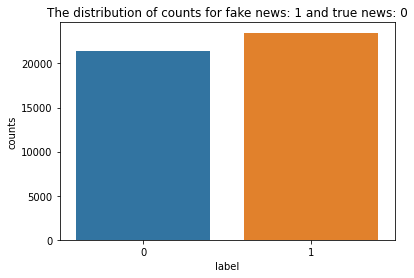

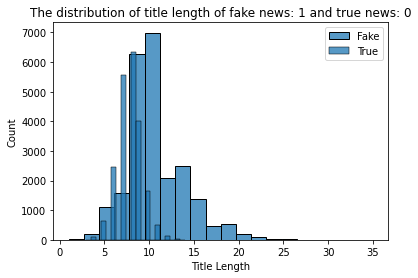

In [22]:
# EDA
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# whether the data is balanced
ax = sns.countplot(x = News["label"], alpha=1.0);
counts = News["label"].value_counts().values
#ax.bar_label(container=ax.containers[0], labels = counts)
plt.xlabel("label")
plt.ylabel("counts")
plt.title("The distribution of counts for fake news: 1 and true news: 0")
plt.show()
plt.close()

# the distribution of title length
News["title_length"] = News["title"].apply(lambda x : len(x.strip().split()))
sns.histplot(News[News["label"] == 1]["title_length"], kde=False, label="Fake", bins=20)
sns.histplot(News[News["label"] == 0]["title_length"], kde=False, label="True", bins=20)
plt.xlabel("Title Length")
plt.title("The distribution of title length of fake news: 1 and true news: 0")
plt.legend()
plt.show()

In [82]:
# split data for training and test
from sklearn.model_selection import train_test_split
X = News["title"].values.tolist()
y = News["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [83]:
# Word Embeddings TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_TI = vectorizer.fit_transform(X_train)
X_test_TI = vectorizer.transform(X_test)

In [84]:
# Chi-square test
from sklearn.feature_selection import chi2

X_features = vectorizer.get_feature_names_out()

_, p = chi2(X_train_TI, y_train)
features = pd.DataFrame({"feature":X_features, "score":1-p})
features = features[features["score"]>0.95]

X_features = features["feature"].tolist()

In [98]:
vectorizer = TfidfVectorizer(vocabulary = X_features)
X_train_TI = vectorizer.fit_transform(X_train)
X_test_TI = vectorizer.transform(X_test)

In [101]:
import scipy.sparse

featureslist = vectorizer.vocabulary_
X_train_final = pd.DataFrame.sparse.from_spmatrix(X_train_TI, columns = featureslist)
X_test_final = pd.DataFrame.sparse.from_spmatrix(X_test_TI, columns = featureslist)

In [ ]:
X_train_final.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/X_train_TI.csv",index=False)
X_test_final.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/X_test_TI.csv",index=False)

In [103]:
pd.DataFrame(y_train).to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_train.csv",index=False)
pd.DataFrame(y_test).to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_test.csv",index=False)